Check Python version

In [1]:
!python --version

Python 3.10.14


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_name)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

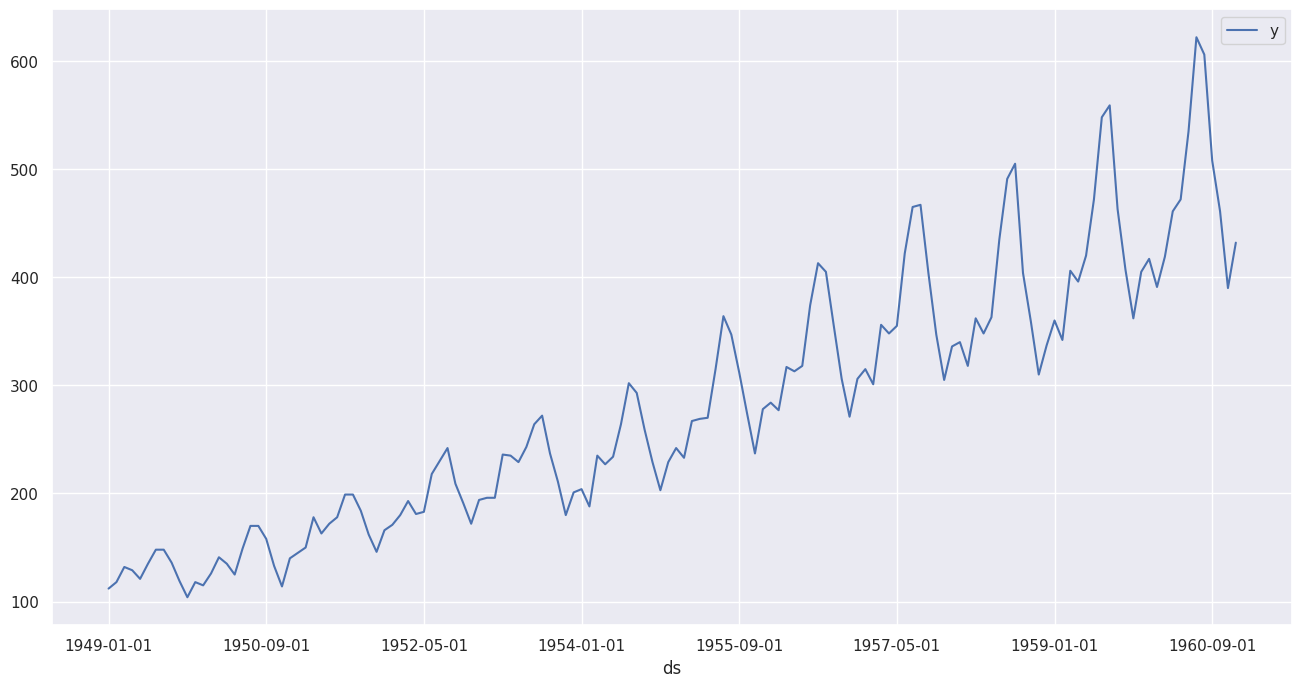

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# Default model request

# Customized model request
# model_request = {
#     'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
#     'scorers': ['mase', 'smape'],
#     'params': {
#         'preprocessors': [
#             # {'type': 'dartsimputer'},
#             # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_rnn',
#              'params': {
#                  'model': 'LSTM',
#                  'hidden_dim': 10,
#                  'n_rnn_layers': 3,
#             }},
#             {'type': 'darts_nlinear'},
#             {'type': 'darts_dlinear'},
#             {'type': 'darts_blockrnn'},
#         ],
#     },
# }

This is for JSON model_request

In [17]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [18]:
file_path = 'model_request.yaml'
# For reading the model request from a yaml file
with open(file_path, 'r') as file:
    model_request = yaml.safe_load(file)

print(model_request)

{'type': 'meta_wa', 'scorers': ['mase', 'smape'], 'params': {'preprocessors': [{'type': 'minmaxscaler'}], 'base_models': [{'type': 'darts_nlinear'}, {'type': 'darts_dlinear'}]}}


Train API JSON Payload

In [19]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [20]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [21]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [22]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [23]:
%%time
response = requests.post(url, json=api_json, verify=False)
print(response)
print()

/home/kevin/.conda/envs/dsybil/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dsybil-test.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

CPU times: user 46.2 ms, sys: 4.7 ms, total: 51 ms
Wall time: 55.5 s


In [24]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEDCAdcAQAAXAEAF1wBAIAElb0QAQAAAAAAjA9tb2RlbHMucGlwZWxpbmWUjAhQaXBlbGluZZSTlCmBlH2UKIwMdHJhbnNmb3JtZXJzlF2UjBNtb2RlbHMucHJlcHJvY2Vzc29ylIwMTWluTWF4U2NhbGVylJOUKYGUfZQojANtaW6USwCMA21heJRLAYwEbWluX5SMFW51bXB5LmNvcmUubXVsdGlhcnJheZSMBnNjYWxhcpSTlIwFbnVtcHmUjAVkdHlwZZSTlIwCZjiUiYiHlFKUKEsDjAE8lE5OTkr/////Sv////9LAHSUYkMIAAAAAAAAWkCUhpRSlIwEbWF4X5RoEWgXQwgAAAAAAHCDQJSGlFKUdWJhjAVtb2RlbJSMFG1vZGVscy5tb2RlbHdyYXBwZXJzlIwLTWV0YU1vZGVsV0GUk5QpgZR9lCiMC2Jhc2VfbW9kZWxzlF2UKGgijAxEYXJ0c1dyYXBwZXKUk5QpgZR9lChoIYwgZGFydHMubW9kZWxzLmZvcmVjYXN0aW5nLm5saW5lYXKUjAxOTGluZWFyTW9kZWyUk5QpgZR9lCiMEF9yYW5kb21faW5zdGFuY2WUjBRudW1weS5yYW5kb20uX3BpY2tsZZSMEl9fcmFuZG9tc3RhdGVfY3RvcpSTlIwHTVQxOTkzN5RoM4wUX19iaXRfZ2VuZXJhdG9yX2N0b3KUk5SGlFKUfZQojA1iaXRfZ2VuZXJhdG9ylIwHTVQxOTkzN5SMBXN0YXRllH2UKIwDa2V5lGgPjAxfcmVjb25zdHJ1Y3SUk5RoEowHbmRhcnJheZSTlEsAhZRDAWKUh5RSlChLAU1wAoWUaBSMAnU0lImIh5RSlChLA2gYTk5OSv////9K/////0sAdJRiiULACQAAzKoekxL/W0GkL8lBWlX1JOI3TglKoab6pJd67zrH+HIgKzJSEVj0uMOOyOhD+zKzM583+ykGd2v+C

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [25]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [26]:
model = train_json_out['model']

Forecast API JSON Payload

In [27]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [28]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [29]:
%%time
response = requests.post(url, json=api_json, verify=False)
print(response)
print()

/home/kevin/.conda/envs/dsybil/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dsybil-test.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>

CPU times: user 36.3 ms, sys: 1.16 ms, total: 37.4 ms
Wall time: 692 ms


In [30]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1961-01-01', 453.1500856481249],
  ['1961-02-01', 434.3711354519581],
  ['1961-03-01', 452.18946023670844],
  ['1961-04-01', 488.75215822234173],
  ['1961-05-01', 525.9112814378836],
  ['1961-06-01', 594.9212939642126],
  ['1961-07-01', 674.5428196098484],
  ['1961-08-01', 654.6388698863569],
  ['1961-09-01', 568.8379744877927],
  ['1961-10-01', 495.6174511759101],
  ['1961-11-01', 440.0958294487259],
  ['1961-12-01', 459.0378113368156],
  ['1962-01-01', 486.9001898834317],
  ['1962-02-01', 473.1005652299389],
  ['1962-03-01', 482.9206741691348],
  ['1962-04-01', 524.7706208288744],
  ['1962-05-01', 575.1267417757022],
  ['1962-06-01', 655.2438041035755],
  ['1962-07-01', 731.3806985230741],
  ['1962-08-01', 712.6403516661345],
  ['1962-09-01', 623.4350753689414],
  ['1962-10-01', 541.1690513137239],
  ['1962-11-01', 484.1052606474492],
  ['1962-12-01', 497.08424354156324]]}

Combine forecast dates and output

In [31]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [32]:
forecast_df.shape

(24, 2)

In [33]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [34]:
forecast_df.head()

,ds,y
0,1961-01-01,453.150086
1,1961-02-01,434.371135
2,1961-03-01,452.189460
3,1961-04-01,488.752158
4,1961-05-01,525.911281


In [35]:
forecast_df.tail()

,ds,y
19,1962-08-01,712.640352
20,1962-09-01,623.435075
21,1962-10-01,541.169051
22,1962-11-01,484.105261
23,1962-12-01,497.084244


Plot train and forecast side-by-side

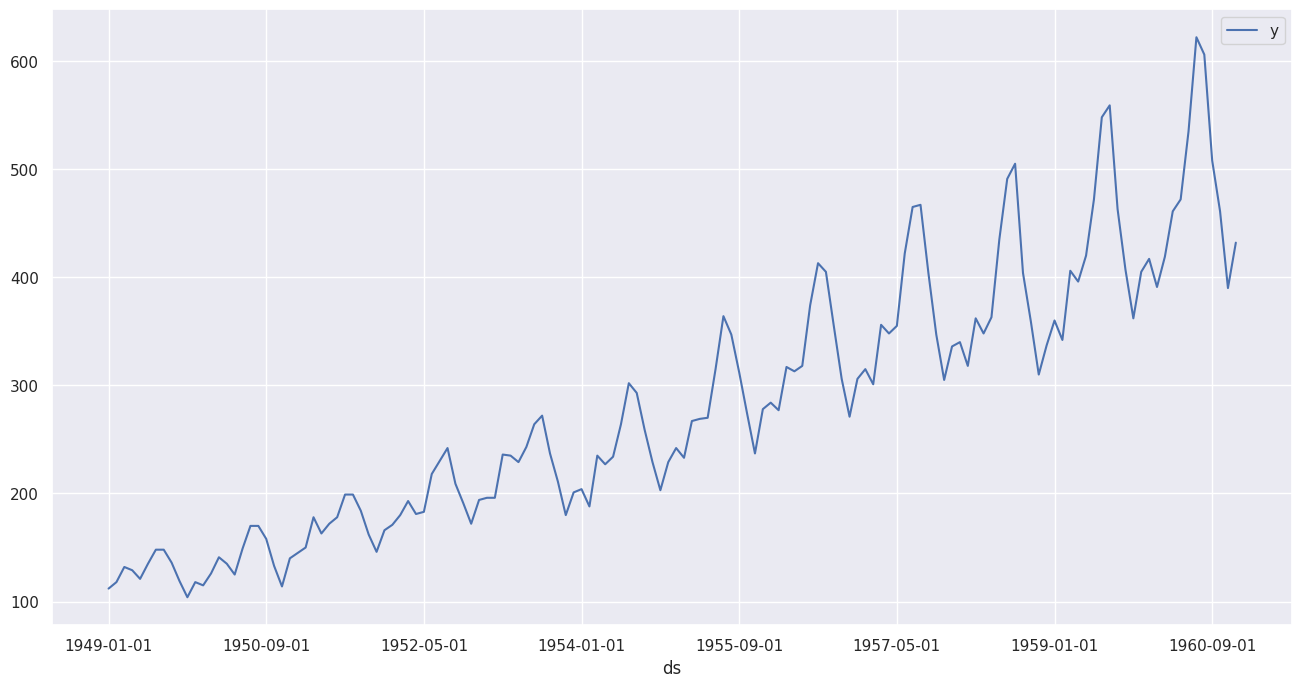

In [36]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

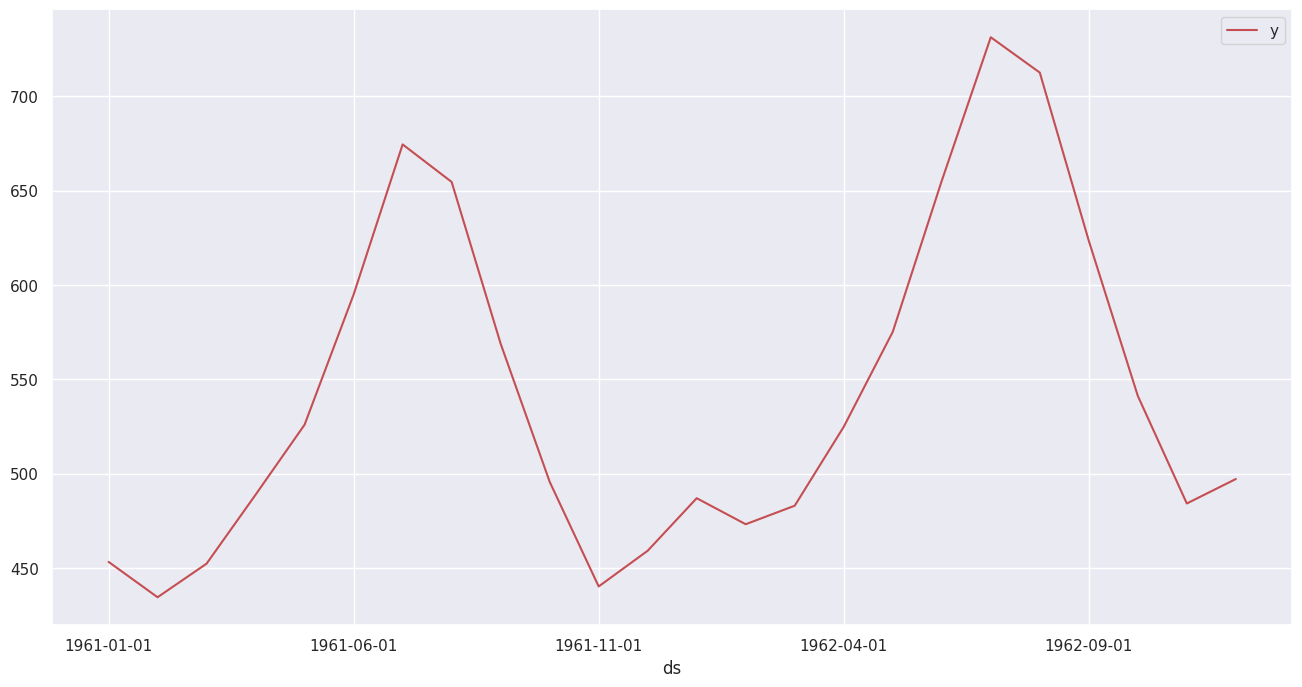

In [37]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [38]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [39]:
df.shape

(168, 3)

In [40]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [41]:
df.tail()

,ds,y,color
163,1962-08-01,712.640352,r
164,1962-09-01,623.435075,r
165,1962-10-01,541.169051,r
166,1962-11-01,484.105261,r
167,1962-12-01,497.084244,r


Plot combined train and forecast sets with the vertical black line as the cut-off

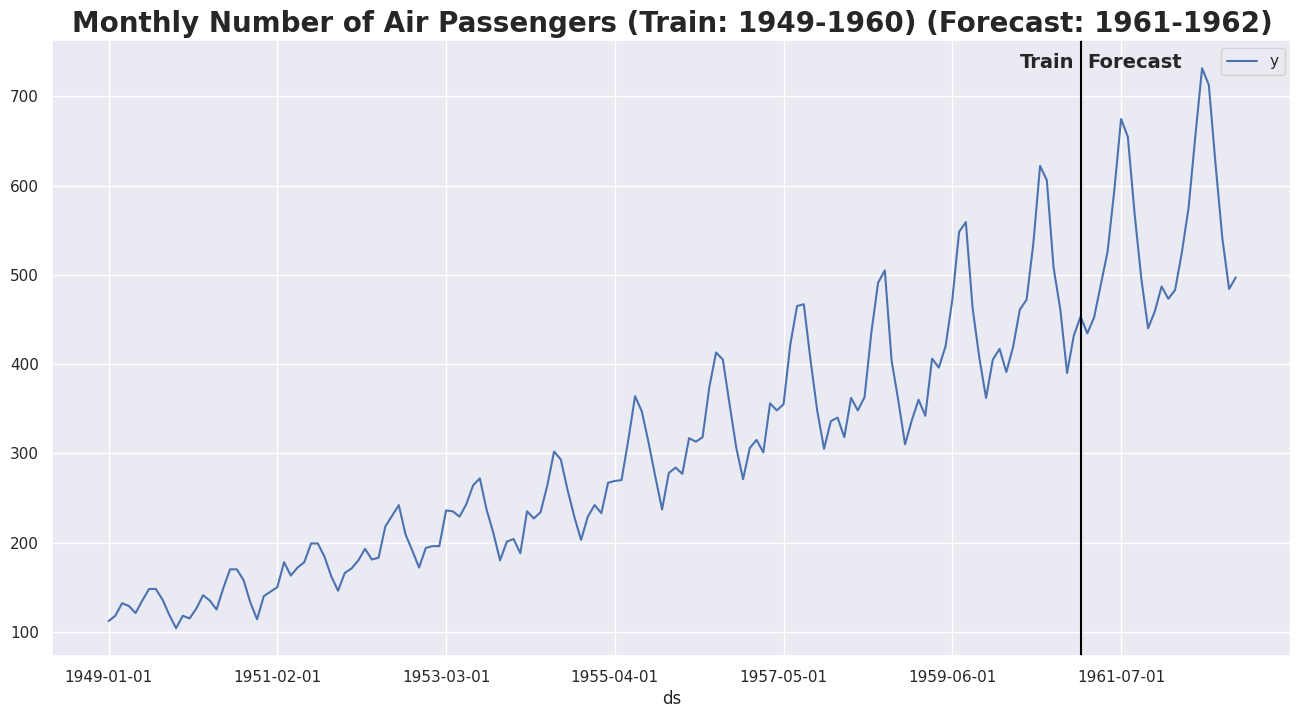

In [42]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();